In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import os
from __future__ import print_function, division
from builtins import range, input
from glob import glob
import math

import keras
from keras import backend as K
from keras import optimizers, losses, activations, models, applications

#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.inception_v3 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

#from keras.applications.xception import Xception
#from keras.applications.xception import preprocess_input

from keras.models import Model, Sequential

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate

from keras.optimizers import SGD

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

print('Keras Version: ',keras.__version__)
print('Tensorflow Version: ',tf.__version__)

Using TensorFlow backend.


Keras Version:  2.2.4
Tensorflow Version:  1.14.0


In [0]:
#novel mkdir function
def mkdir(p):
  if not os.path.exists(p):
    os.mkdir(p)
    
def link(src, dst):
  if not os.path.exists(dst):
    os.symlink(src, dst, target_is_directory=True)

In [0]:
#check if dataset exists, if exists skip next cell
print(glob('drive/My Drive/ML/*'))

['drive/My Drive/ML/large_file', 'drive/My Drive/ML/vgg_tl.ipynb', 'drive/My Drive/ML/pneumonia_tl.ipynb', 'drive/My Drive/ML/pneumonia_tl_vgg16.ipynb', 'drive/My Drive/ML/TestFiles', 'drive/My Drive/ML/pneumonia_tl_vgg16_retrained.ipynb', 'drive/My Drive/ML/pneumonia_tl_inception.ipynb', 'drive/My Drive/ML/Copy of pneumonia_tl_vgg16_retrained.ipynb']


In [0]:
#mkdir('drive/My Drive/ML/large_file') 
#
#from zipfile import ZipFile
### Create a ZipFile Object and load sample.zip in it
#with ZipFile('drive/My Drive/ML/large_file/chest_xray.zip', 'r') as zipObj:
#   # Extract all the contents of zip file in different directory
#   zipObj.extractall('drive/My Drive/ML/large_file/')

In [0]:
train_path = 'drive/My Drive/ML/large_file/chest_xray/train'
valid_path = 'drive/My Drive/ML/large_file/chest_xray/val'
test_path = 'drive/My Drive/ML/large_file/chest_xray/test'

In [0]:
print(glob(train_path+'/*'))
print(glob(valid_path+'/*'))
print(glob(test_path+'/*'))

['drive/My Drive/ML/large_file/chest_xray/train/PNEUMONIA', 'drive/My Drive/ML/large_file/chest_xray/train/NORMAL']
['drive/My Drive/ML/large_file/chest_xray/val/PNEUMONIA', 'drive/My Drive/ML/large_file/chest_xray/val/NORMAL']
['drive/My Drive/ML/large_file/chest_xray/test/PNEUMONIA', 'drive/My Drive/ML/large_file/chest_xray/test/NORMAL']


In [0]:
#number of files
image_files = glob(train_path+'/*/*.jp*g')
valid_image_files = glob(valid_path+'/*/*.jp*g')
test_image_files = glob(test_path+'/*/*.jp*g')

#number of folders
folders=glob(train_path+'/*')

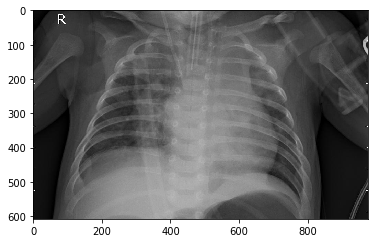

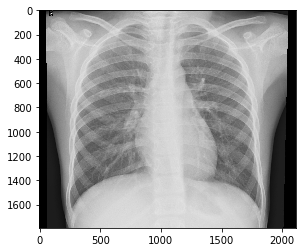

In [0]:
#load a random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

plt.imshow(image.load_img(np.random.choice(test_image_files)))
plt.show()

In [0]:
#set image size, epochs and batch size
IMAGE_SIZE = [150,150]

epochs = 10
batch_size = 16


In [0]:
sgd = SGD(lr=0.0, momentum=0.9, decay=0.0, nesterov=False)

In [0]:
#import base model and freeze top x layers
base_model = VGG16(input_shape= IMAGE_SIZE + [3], weights='imagenet', include_top=False)


W0723 21:48:51.958860 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 21:48:51.962830 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 21:48:51.968182 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 21:48:52.063668 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 5s 0us/step


W0723 21:48:59.271334 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 21:48:59.272986 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:

#x = Sequential()

x = base_model.output
x = GlobalAveragePooling2D()(x)


x = Dense(units=1024, activation='relu')(x)
x = Dropout(0.5)(x)
#x = BatchNormalization()(x)
x = Dense(units=768, activation='relu')(x)
x = Dropout(rate=0.4)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.3)(x)

prediction = Dense(len(folders), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=prediction)

model.summary()

W0723 21:49:00.390811 140433231611776 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
def print_layers(model):
    for idx, layer in enumerate(model.layers):
        print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable))

for layer in base_model.layers[0:15]:
  layer.trainable = False
        
print_layers(model)
#model.trainable_weights

layer 0: input_1, trainable: False
layer 1: block1_conv1, trainable: False
layer 2: block1_conv2, trainable: False
layer 3: block1_pool, trainable: False
layer 4: block2_conv1, trainable: False
layer 5: block2_conv2, trainable: False
layer 6: block2_pool, trainable: False
layer 7: block3_conv1, trainable: False
layer 8: block3_conv2, trainable: False
layer 9: block3_conv3, trainable: False
layer 10: block3_pool, trainable: False
layer 11: block4_conv1, trainable: False
layer 12: block4_conv2, trainable: False
layer 13: block4_conv3, trainable: False
layer 14: block4_pool, trainable: False
layer 15: block5_conv1, trainable: True
layer 16: block5_conv2, trainable: True
layer 17: block5_conv3, trainable: True
layer 18: block5_pool, trainable: True
layer 19: global_average_pooling2d_1, trainable: True
layer 20: dense_1, trainable: True
layer 21: dropout_1, trainable: True
layer 22: dense_2, trainable: True
layer 23: dropout_2, trainable: True
layer 24: dense_3, trainable: True
layer 25: dr

In [0]:

model.compile(loss='binary_crossentropy'#, optimizer='rmsprop'
              , optimizer=sgd, metrics=['acc'])

W0723 21:49:06.631731 140433231611776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 21:49:06.671971 140433231611776 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
#data augmentation
gen = ImageDataGenerator(
    rescale=1. / 255,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    #preprocessing_function=preprocess_input
)

#data augmentation
val_gen = ImageDataGenerator(
    rescale=1. / 255
)

In [0]:
#validation data without augmentation
test_gen = val_gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)

print(test_gen.class_indices)


Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


min: 0.0 max: 1.0


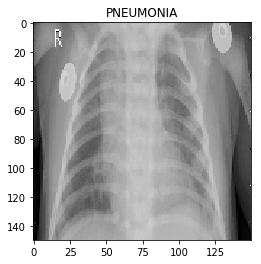

In [0]:
#get lables for CM
labels = [None]* len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
  labels[v] = k
  
for x, y in test_gen:
  print('min:', x[0].min(), 'max:', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [0]:
train_generator = gen.flow_from_directory(
  train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size,
)

valid_generator = val_gen.flow_from_directory(
  valid_path,
    target_size = IMAGE_SIZE,
    shuffle = False,
    batch_size = 1,
)

test_generator = val_gen.flow_from_directory(
  test_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 5.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate  


lrate = LearningRateScheduler(step_decay)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto',
    min_delta=0.0001, 
    cooldown=1, 
    min_lr=0.0000001
)

# checkpoint file
file_path="drive/My Drive/ML/large_file/chest_xray/vgg16_retrained.best.hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

#early stopping monitor
early = EarlyStopping(monitor="acc", mode="max", patience=5)

callbacks_list = [lrate, reduce, checkpoint, early] 




In [0]:
r = model.fit_generator(train_generator, 
                        validation_data = test_generator,
                              epochs=epochs, 
                              shuffle=True, 
                              verbose=True,
                              steps_per_epoch = len(image_files) //batch_size,
                              validation_steps= len(test_image_files) //batch_size,
                              callbacks=callbacks_list)

Epoch 1/10
326/326 [==============================] - 120s 370ms/step - loss: 0.0878 - acc: 0.9686 - val_loss: 0.3428 - val_acc: 0.8990

Epoch 00001: val_acc improved from -inf to 0.89904, saving model to drive/My Drive/ML/large_file/chest_xray/weights.best.hdf5
Epoch 2/10
326/326 [==============================] - 119s 364ms/step - loss: 0.0925 - acc: 0.9645 - val_loss: 0.7218 - val_acc: 0.7660

Epoch 00002: val_acc did not improve from 0.89904
Epoch 3/10
326/326 [==============================] - 118s 362ms/step - loss: 0.0722 - acc: 0.9735 - val_loss: 0.5659 - val_acc: 0.8478

Epoch 00003: val_acc did not improve from 0.89904
Epoch 4/10
326/326 [==============================] - 118s 363ms/step - loss: 0.0859 - acc: 0.9686 - val_loss: 0.2339 - val_acc: 0.9311

Epoch 00004: val_acc improved from 0.89904 to 0.93109, saving model to drive/My Drive/ML/large_file/chest_xray/weights.best.hdf5
Epoch 5/10
326/326 [==============================] - 119s 364ms/step - loss: 0.0531 - acc: 0.980

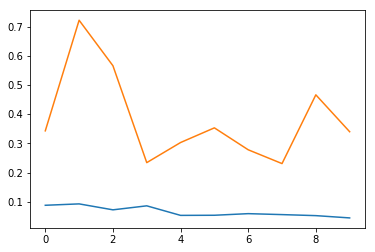

In [0]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()


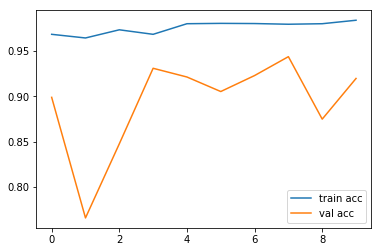

In [0]:
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [0]:
#load weights from file
model.load_weights(file_path)

In [0]:
#taken directly from scickit learn docs on CM
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


def y2indicator(Y):
  K = len(set(Y))
  N = len(Y)
  I = np.empty((N, K))
  I[np.arange(N), Y] = 1
  return I

def get_confusion_matrix(data_path, N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 8):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm

Generating confusion matrix 5216
Found 5216 images belonging to 2 classes.
Confusion matrix, without normalization
[[1339    2]
 [ 141 3734]]


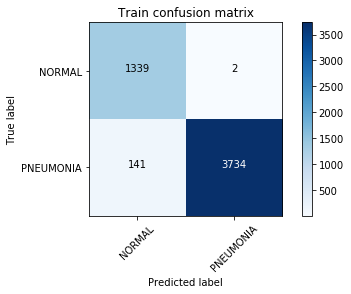

In [0]:
cm =  get_confusion_matrix(train_path, len(image_files))
#print(cm)
plot_confusion_matrix(cm, labels, title='Train confusion matrix')
plt.show()

Generating confusion matrix 624
Found 624 images belonging to 2 classes.
Confusion matrix, without normalization
[[195  39]
 [  6 384]]


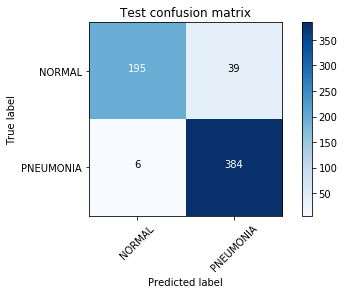

In [0]:
test_cm = get_confusion_matrix(test_path, len(test_image_files))
#print(test_cm)
plot_confusion_matrix(test_cm, labels, title='Test confusion matrix')
plt.show()

In [0]:
# Calculate Precision and Recall
tn, fp, fn, tp = test_cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.91
